In [19]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import asdfghjkl
from torch.distributions import MultivariateNormal
from torch.autograd import grad
from tqdm import trange

### Hyperparameters

In [20]:
torch.manual_seed(5)
train_set_size = 100
epochs = 10000
lr = 5e-4
vi_std_init = 1
log_hessian_scaling = 0.5

### Plot hyperparameters

In [21]:
padding = 1.5
x_bounds = (0, 6)
y_bounds = x_bounds
n_weight_samples = 100
colormap = "BrBG"
alpha=0.3
levels=40
tick_levels=5

### Loss Landscape

In [22]:
g1 = MultivariateNormal(torch.tensor([2,2]), torch.eye(2))
g2 = MultivariateNormal(torch.tensor([4,4]), 0.25*torch.eye(2))
def get_lik(x):
    return (train_set_size * (g1.log_prob(x).exp() + g2.log_prob(x).exp()) / 2).log() # normalizing factor to scale to 1, multiply by train set size, assume all data comes from exactly same distribution
    # return 2 * g1.log_prob(x) + 5 * g2.log_prob(x) # normalizing factor to scale to 1, multiply by train set size, assume all data comes from exactly same distribution

In [23]:
weight_prior_mean = 0
weight_prior_variance = 10
weight_prior = torch.distributions.MultivariateNormal(torch.full((1,2), weight_prior_mean), weight_prior_variance * torch.eye(2))

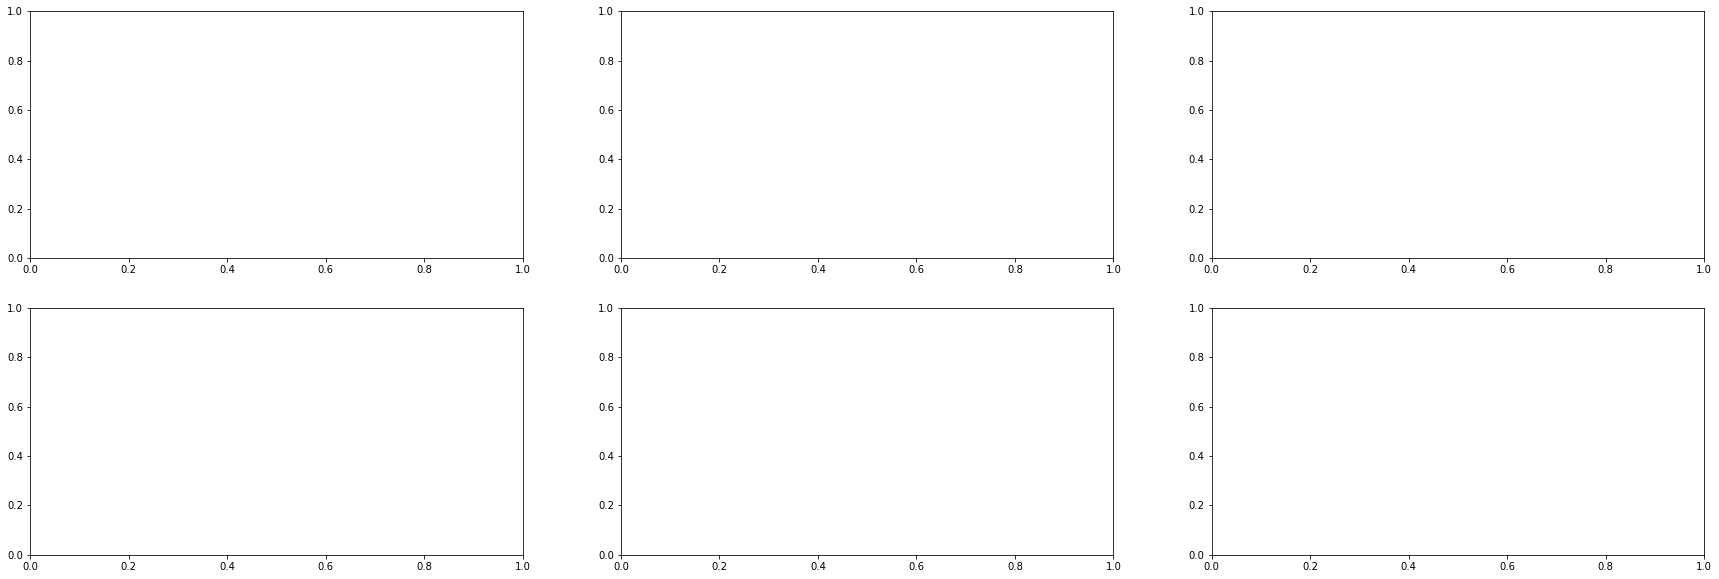

In [24]:
fig, axs = plt.subplots(2,3, figsize=(30,10), facecolor="w");
axs = axs.flat;

In [25]:
weight_space_x = torch.linspace(x_bounds[0], x_bounds[1], n_weight_samples)
weight_space_y = torch.linspace(y_bounds[0], y_bounds[1], n_weight_samples)
log_posterior_grid = torch.zeros((n_weight_samples, n_weight_samples))
log_lik_grid = torch.zeros((n_weight_samples, n_weight_samples))
for id1, weight1 in enumerate(weight_space_x):
    for id2, weight2 in enumerate(weight_space_y):
        new_weights = torch.tensor([[weight1, weight2]])
        log_lik = get_lik(new_weights)#.log()
        log_prior = weight_prior.log_prob(new_weights)
        log_posterior = (log_lik + log_prior)
        log_lik_grid[id1, id2] = -log_lik
        log_posterior_grid[id1, id2] = -log_posterior

cax2 = axs[1].contourf(weight_space_x, weight_space_y, log_lik_grid, cmap=colormap, alpha=alpha, levels=levels)
fig.colorbar(cax2, ax=axs[1], ticks=torch.linspace(log_lik_grid.min(), log_lik_grid.max(), tick_levels))
axs[1].set_title("Negative log likelihood")

cax3 = axs[2].contourf(weight_space_x, weight_space_y, log_posterior_grid, cmap=colormap, alpha=alpha, levels=levels)
fig.colorbar(cax3, ax=axs[2], ticks=torch.linspace(log_posterior_grid.min(), log_posterior_grid.max(), tick_levels))
axs[2].set_title("Negative log joint/Unnormalized posterior");

In [26]:
log_hessian_penatly_grid = torch.zeros((n_weight_samples, n_weight_samples))
for id1, weight1 in enumerate(weight_space_x):
    for id2, weight2 in enumerate(weight_space_y):
        model = torch.tensor([weight1, weight2], requires_grad=True)
        log_lik = get_lik(model)#.log()
        log_prior = weight_prior.log_prob(model)
        log_joint = (log_prior + log_lik).sum() # somehow have to do sum for asdl
        neg_log_joint_grad = grad(-log_joint, model, create_graph=True)[0]
        ggn = torch.outer(neg_log_joint_grad, neg_log_joint_grad)
        # diag_ggn = neg_log_joint_grad.square()
        log_hessian = ggn.det().log()
        log_hessian = ggn.diag().log().sum()
        # log_hessian = diag_ggn.log().sum()
        if torch.isinf(log_hessian) or torch.isnan(log_hessian):
            print("Log gessian is", log_hessian, ggn, neg_log_joint_grad)
            raise ValueError
        loss = - log_joint + log_hessian_scaling * log_hessian
        log_hessian_penatly_grid[id1, id2] = loss.detach()
cax0 = axs[0].contourf(weight_space_x, weight_space_y, log_hessian_penatly_grid, cmap=colormap, alpha=alpha, levels=levels)
fig.colorbar(cax0, ax=axs[0], ticks=torch.linspace(log_hessian_penatly_grid.min(), log_hessian_penatly_grid.max(), tick_levels))
axs[0].set_title("Loss landscape for log hessian penatly");

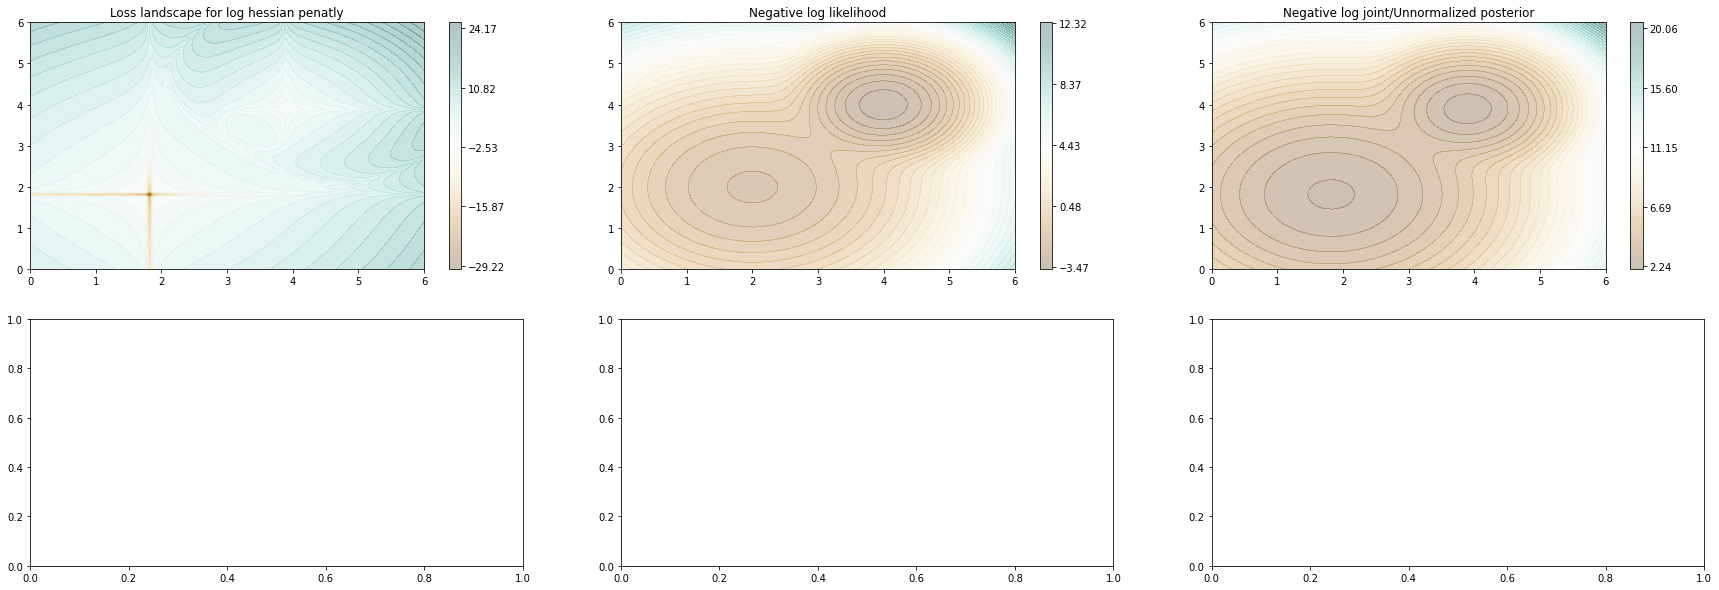

In [27]:
fig

### MAP model

In [28]:
map_model = torch.tensor([2.5,5], dtype=torch.float, requires_grad=True)
map_tracking = map_model.detach().clone().unsqueeze(dim=0)
optimizer = torch.optim.SGD([map_model], lr=lr)
print("Computing MAP estimate")
for i in trange(epochs):
    optimizer.zero_grad()
    log_lik = get_lik(map_model)#.log()
    log_prior = weight_prior.log_prob(map_model)
    loss = - (log_prior + log_lik)
    loss.backward()
    optimizer.step()
    map_tracking = torch.cat([map_tracking, map_model.detach().clone().unsqueeze(dim=0)], dim=0)
axs[1].plot(map_tracking[:,0], map_tracking[:,1], label="MAP")
axs[2].plot(map_tracking[:,0], map_tracking[:,1], label="MAP")


Computing MAP estimate


100%|██████████| 10000/10000 [00:04<00:00, 2418.90it/s]


### Laplace approximation for MAP

In [29]:
log_lik_hessian = asdfghjkl.hessian(-get_lik(map_model), map_model)
log_prior_hessian = 2 / weight_prior_variance**2 # hessian of negative log gaussian
laplace_covariance = torch.inverse(log_lik_hessian + log_prior_hessian)
laplace_distribution = torch.distributions.MultivariateNormal(map_model, laplace_covariance)


laplace_log_posterior_grid = torch.zeros((n_weight_samples, n_weight_samples))
with torch.no_grad():
    for id1, weight1 in enumerate(weight_space_x):
        for id2, weight2 in enumerate(weight_space_y):
            laplace_log_posterior_grid[id1, id2] = -laplace_distribution.log_prob(torch.tensor([weight1, weight2]))

cax4 = axs[3].contourf(weight_space_x, weight_space_y, laplace_log_posterior_grid, cmap=colormap, alpha=alpha, levels=levels)
fig.colorbar(cax4, ax=axs[3], ticks=torch.linspace(laplace_log_posterior_grid.min(), laplace_log_posterior_grid.max(), tick_levels))
axs[3].set_title("Laplace approximation of posterior");

### Log-hessian penalty model, diagonal approximation

In [30]:
# # define model
lvi_model = map_tracking[0].detach().clone()
lvi_model.requires_grad = True
lvi_tracking = lvi_model.detach().clone().unsqueeze(dim=0)
lvi_optimizer = torch.optim.SGD([lvi_model], lr=1e-4)

print("Computing Log-Hessian penalty")
for i in trange(epochs):
    if torch.any(torch.isnan(lvi_model)):
        print("Weights are nan in epoch", i)
        break
    lvi_optimizer.zero_grad()
    log_lik = get_lik(lvi_model)#.log()
    log_prior = weight_prior.log_prob(lvi_model)
    log_joint = (log_prior + log_lik).sum() # somehow have to do sum for asdl
    neg_log_joint_grad = grad(-log_joint, lvi_model, create_graph=True)[0]
    ggn = torch.outer(neg_log_joint_grad, neg_log_joint_grad)
    log_hessian = ggn.diag().log().sum()
    # log_hessian = - ggn.diag().sum()
    loss = - log_joint + log_hessian_scaling * log_hessian#asdfghjkl.hessian(-log_joint, lvi_model, create_graph=True).log().sum()
    loss.backward()
    lvi_optimizer.step()
    lvi_tracking = torch.cat([lvi_tracking, lvi_model.detach().clone().unsqueeze(dim=0)], dim=0)

axs[0].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI")
axs[1].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI")
axs[2].plot(lvi_tracking[:,0], lvi_tracking[:,1], label="Laplace_VI");

Computing Log-Hessian penalty


100%|██████████| 10000/10000 [00:08<00:00, 1207.35it/s]


### Variational Inference

In [31]:
vi_weight_mean = map_tracking[0].detach().clone()
vi_weight_mean.requires_grad = True
vi_weight_std = torch.full((2,), vi_std_init, dtype=torch.float, requires_grad=True)
vi_optimizer = torch.optim.SGD([vi_weight_mean, vi_weight_std], lr=lr)
vi_weight_mean_tracking = vi_weight_mean.detach().clone().unsqueeze(dim=0)
for i in trange(epochs):
    vi_optimizer.zero_grad()
    weight_samples = vi_weight_mean + vi_weight_std * torch.randn(2)
    log_lik = get_lik(weight_samples)
    log_prior = weight_prior.log_prob(weight_samples)
    log_joint = (log_prior + log_lik)
    entropy = 0.5 * vi_weight_std.log().sum()
    loss = - (log_joint + entropy)
    loss.backward()
    vi_optimizer.step()
    vi_weight_mean_tracking = torch.cat([vi_weight_mean_tracking, vi_weight_mean.detach().clone().unsqueeze(dim=0)], dim=0)

axs[1].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI")
axs[2].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI")
axs[0].plot(vi_weight_mean_tracking[:,0], vi_weight_mean_tracking[:,1], label="normal VI");

100%|██████████| 10000/10000 [00:04<00:00, 2220.24it/s]


In [32]:
vi_distribution = MultivariateNormal(vi_weight_mean, vi_weight_std.square().diag())
vi_log_posterior_grid = torch.zeros((n_weight_samples, n_weight_samples))
with torch.no_grad():
    for id1, weight1 in enumerate(weight_space_x):
        for id2, weight2 in enumerate(weight_space_y):
            vi_log_posterior_grid[id1, id2] = -vi_distribution.log_prob(torch.tensor([weight1, weight2]))
cax5 = axs[4].contourf(weight_space_x, weight_space_y, vi_log_posterior_grid, cmap=colormap, alpha=alpha, levels=levels)
fig.colorbar(cax5, ax=axs[4], ticks=torch.linspace(vi_log_posterior_grid.min(), vi_log_posterior_grid.max(), tick_levels))
axs[4].set_title("VI approximation of posterior");

In [33]:
# plot formatting
for ax in axs:
    ax.legend()
    ax.set_xlim(x_bounds[0], x_bounds[1])
    ax.set_ylim(y_bounds[0], y_bounds[1])
plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

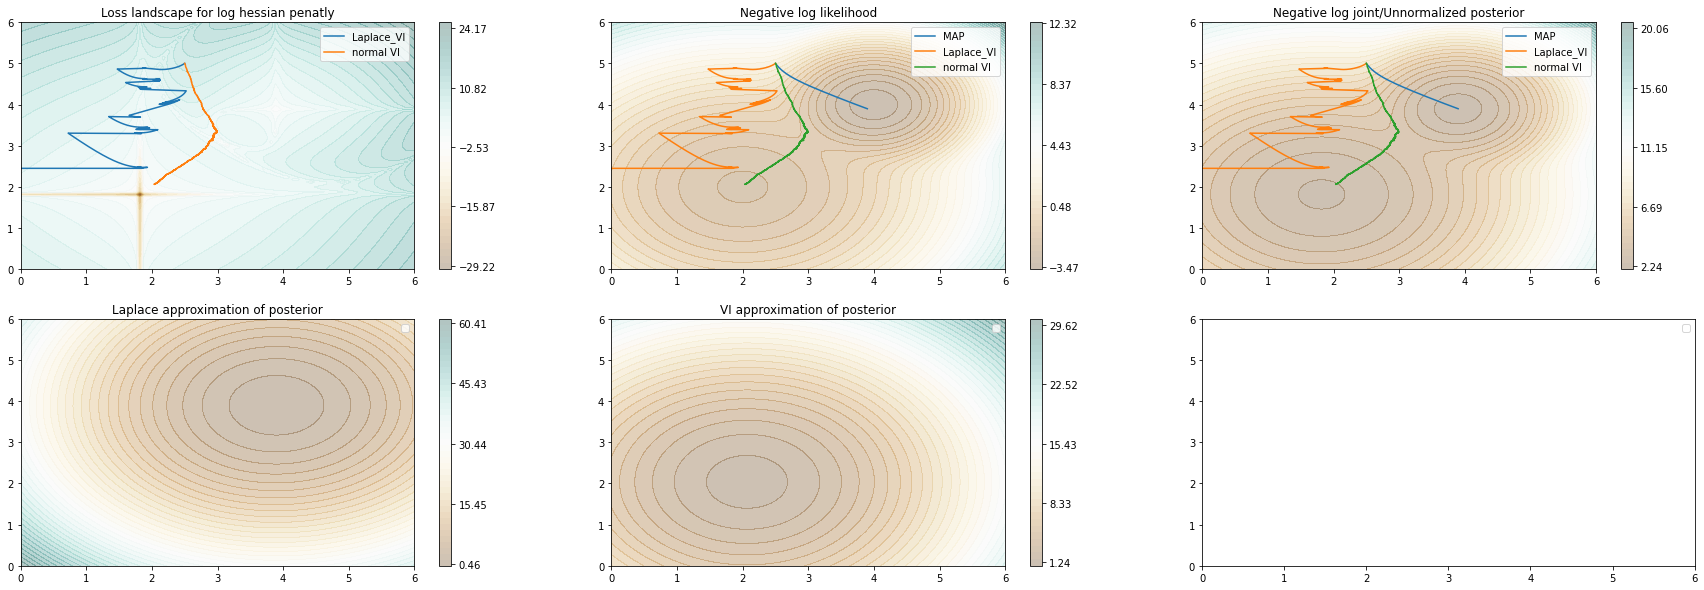

In [34]:
fig

### Observations
- looks like hessian penalty takes same path as VI
- however, as soon as we come to low loss, gradient gets 0 thus loghessian explodes, this leads to very instable behaviour